# Exercise 03 - Image Classfication of German Traffic Signs

In this exercise, it is now up to you to define a (fully connected) neural network model for image classification, compile the training process, train the network, and make predictions on unseen data. Please refer to the previous exercises if you need help.

As data, we use the german traffic sign benchmark dataset, which provives images of traffic signs and the respective labels for sign categories.

## Learning objectives
- get familiar with ImageDataGenerator for loading image data
- try data augmentation
- practice setting up a training and adapting the network architecture
- try different optimizers

## Choose a GPU

Choose a not used GPU as seen in the previous notebooks.

In [1]:
!nvidia-smi

Wed Nov 22 13:45:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:01:00.0 Off |                  Off |
| 33%   29C    P8    16W / 230W |      3MiB / 16125MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 5000     Off  | 00000000:24:00.0 Off |                  Off |
| 33%   

In [2]:
USE_GPU = 6

In [3]:
# Import TensorFlow 
import tensorflow as tf

# Print the installed TensorFlow version
print(f'TensorFlow version: {tf.__version__}\n')

# Get all GPU devices on this server
gpu_devices = tf.config.list_physical_devices('GPU')

# Print the name and the type of all GPU devices
print('Available GPU Devices:')
for gpu in gpu_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set only the GPU specified as USE_GPU to be visible
tf.config.set_visible_devices(gpu_devices[USE_GPU], 'GPU')

# Get all visible GPU  devices on this server
visible_devices = tf.config.get_visible_devices('GPU')

# Print the name and the type of all visible GPU devices
print('\nVisible GPU Devices:')
for gpu in visible_devices:
    print(' ', gpu.name, gpu.device_type)
    
# Set the visible device(s) to not allocate all available memory at once,
# but rather let the memory grow whenever needed
for gpu in visible_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-11-22 13:45:56.412606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-22 13:45:57.310128: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


TensorFlow version: 2.12.0

Available GPU Devices:
  /physical_device:GPU:0 GPU
  /physical_device:GPU:1 GPU
  /physical_device:GPU:2 GPU
  /physical_device:GPU:3 GPU
  /physical_device:GPU:4 GPU
  /physical_device:GPU:5 GPU
  /physical_device:GPU:6 GPU
  /physical_device:GPU:7 GPU

Visible GPU Devices:
  /physical_device:GPU:6 GPU


## Using ImageDataGenerators with TensorFlow
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

When working with image data, particularly with large datasets or when performing data augmentation, TensorFlow's `ImageDataGenerator` class provides a convenient and memory-efficient way to load and process images in batches. This is especially useful when dealing with large datasets like the German Traffic Signs dataset, which may not fit entirely into memory.

The `ImageDataGenerator` allows for real-time data augmentation, meaning images are randomly transformed each epoch to artificially expand the dataset with new variations. This includes rotations, shifts, flips, zooms, and other transformations that help the model generalize better by simulating different angles and lighting conditions that occur in real-world scenarios.

Here's a basic example of how to use the `ImageDataGenerator`:

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data augmentation parameters here
train_datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize the images to [0, 1] range
    rotation_range=10,   # Random rotations in degrees
    width_shift_range=0.1, # Random horizontal shifts
    height_shift_range=0.1, # Random vertical shifts
    shear_range=0.1,     # Shear angle in counter-clockwise direction
    zoom_range=0.1,      # Random zoom
    horizontal_flip=False, # Randomly flip inputs horizontally
    fill_mode='nearest'   # Strategy to fill newly created pixels
)

# Assuming you have your training images in a directory
train_generator = train_datagen.flow_from_directory(
    'path_to_train_data',   # Path to the directory with training images
    target_size=(32, 32),   # All images will be resized to 32x32 pixels
    batch_size=32,
    class_mode='categorical' # For multi-class classification (needs one-hot-encoding. We use 'sparse', which does not need one-hot-encoding).
)

# You can then use this generator to train your model via `.fit()`
model.fit(
    train_generator,
    epochs=50
)


## Setup data generators

The data is provided in the shared folder "~/coursematerial/GIS/DeepLearning/gts" that you find in your home directory on the JupyterHub server. You do not need to copy the date in any way, but can directly work with it. Maybe it is a good idea to open a terminal window and explore the directory structure of the data by changing the current directory with the linux command `cd` and listing the content of the current directory with `ls -lh`. You can also run these commands inside the Jupyter notebook by preprending "!", like "!ls -lh" (-l includes more information like file sizes, -h makes the output human readable by showing the sizes in Megabyte instead of bytes if appropriate). You will notice that there are 3 folders under the gts directory called train, validation, and test. These contain the different splits of the images. In each of the 3 folders, you find 43 sub-directories for the 43 categories of traffic signs. The name of the folder specifies the label number. In each folder, you then find the images of the same category.

To provide data to the network, we use the `ImageDataGenerator` class and generate 3 image data generator objects for train, validation, and test, respectively. The generator class already provides functionality to load the input images from files, rescale the color values, change the image width and height, and create batches. You can add data augmentation to try the different methods (see the plots below to check their effects).

The images are color images and are represented using RGB (R=red, G=green, B=blue) colospace. Black is represented by (0,0,0), white by (255,255,255), medium gray by (128,128,128). Red is represented by (255, 0, 0). We get Yellow by adding red and green: (255,255,0). This means that we have three channels with values between 0 and 255 for each pixel and thus the size or shape of an image is (width, height, 3). In the following code, we load the data from the folder and resize the images to a fixed size of 64x64 pixels, so they can be easily handled by our network architecture.

In [4]:
from pathlib import Path
import os
from keras.preprocessing.image import ImageDataGenerator

# define constants about the image width and height as well as the batch size
BATCH_SIZE = 32
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

data_dir = str(Path.home()) + r'/coursematerial/GIS/DeepLearning/gts' # Adapt to your data location if not on jupyter hub

train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

print("\nData generator for training data:")
train_generator = ImageDataGenerator(rescale=1./255,samplewise_center=True, samplewise_std_normalization=True,  rotation_range=10,width_shift_range=0.1,height_shift_range=0.1).flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size = BATCH_SIZE,
        # Use sparse labels (from 0 to 42) instead of one-hot representation
        class_mode='sparse')

print("\nData generator for validation data:")
validation_generator = ImageDataGenerator(rescale=1./255,samplewise_center=True, samplewise_std_normalization=True).flow_from_directory(
        validation_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size= BATCH_SIZE,
        class_mode='sparse')

print("\nData generator for test data:")
test_generator = ImageDataGenerator(rescale=1./255,samplewise_center=True, samplewise_std_normalization=True).flow_from_directory(
        test_dir,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='sparse',
        shuffle=False) # shuffle=False means we get the same order for test data every time


Data generator for training data:
Found 27446 images belonging to 43 classes.

Data generator for validation data:
Found 9427 images belonging to 43 classes.

Data generator for test data:
Found 2336 images belonging to 43 classes.


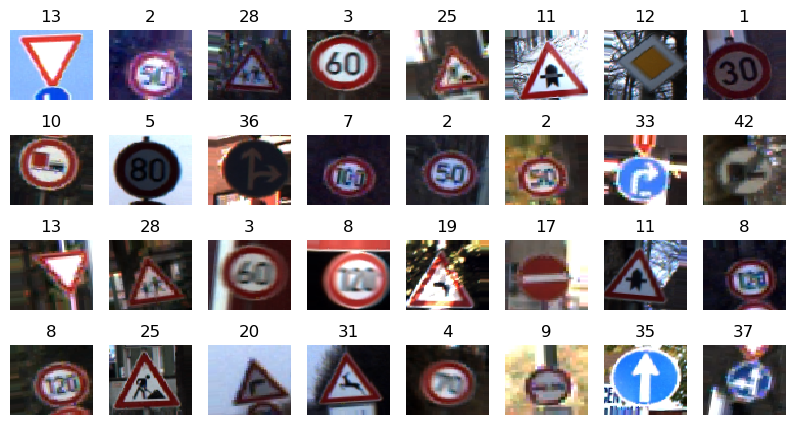

In [5]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np

import itertools

data_batch, labels_batch = train_generator.next()

n_rows = 4
n_cols = 8

plt.figure(figsize = (10,5))

for r,c in itertools.product(range(n_rows), range(n_cols)):
    index = n_cols * r + c
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow((data_batch[index]-data_batch[index].min())/(data_batch[index].max()-data_batch[index].min()), interpolation="nearest", aspect='auto')
    plt.axis('off')
    plt.title(int(labels_batch[index]), fontsize=12) 
plt.subplots_adjust(wspace=0.2, hspace=0.5)

The data generator will provide you with a continuous (and infinite) sequence of data batches. Use the `next()` method of the generator object to get the next batch. (Typically, you would use the generator in a loop like an iterable object.) This is shown in the following, but the loop is stopped after printing the shape of the returned data in the first iteration, as otherwise it would run forever.

In [6]:
print("Length of train generator (number of batches):", len(train_generator))

for x, y in train_generator:
    print(x.shape, y.shape)
    break

Length of train generator (number of batches): 858
(32, 64, 64, 3) (32,)


We can also access the data as batches by using an index from 0 to 857, since there are 857 batches. Be aware that the data is always returned as a pair of inputs and labels.

In [7]:
print(train_generator[3][0].shape) # input
print(train_generator[3][1].shape) # labels

(32, 64, 64, 3)
(32,)


The last batch only holds 22 data items.

In [8]:
print(train_generator[857][0].shape) # input
print(train_generator[857][1].shape) # labels

(22, 64, 64, 3)
(22,)


You can use the index operator to access each of the 32 data items individually, e.g. the image and label of data item at index 6.

In [9]:
x, y = train_generator.next()

print('Data sample image shape:', x[6].shape)
print('Data sample label shape:', y[6].shape)

Data sample image shape: (64, 64, 3)
Data sample label shape: ()


The next cell plots random data from the train generator with their labels.

Repeat the above cell to get a different batch of data.

Now, you should be ready to go with training a neural network to classify these images. 

##  Defining the neural network model with convolutions

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

Construct a sequential model and store it in the variable model.

In [11]:
# old model without convolutions
#model = Sequential([
#    Flatten(input_shape=(64, 64, 3)),
#    Dense(128, activation="relu"),
#    Dense(64, activation="relu"),
#    Dense(43, activation="softmax")])

from tensorflow.keras.layers import Conv2D, MaxPool2D

model = Sequential([
    Conv2D(filters=32, kernel_size=(7,7), activation ='relu', input_shape=(64, 64, 3)),
    MaxPool2D(2,2),
    Conv2D(filters=64, kernel_size=(7,7), activation ='relu'),
    MaxPool2D(2,2),
    Conv2D(filters=128, kernel_size=(7,7), activation ='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(43, activation='softmax') # number of classes.
])

2023-11-22 13:46:01.421502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12900 MB memory:  -> device: 6, name: Quadro RTX 5000, pci bus id: 0000:c1:00.0, compute capability: 7.5


Print the summary of the model.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        100416    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         401536    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [13]:
print(type(model.weights))

print(len(model.weights))
print(model.weights[0])

<class 'list'>
10
<tf.Variable 'conv2d/kernel:0' shape=(7, 7, 3, 32) dtype=float32, numpy=
array([[[[-1.81226321e-02,  3.18387970e-02,  3.43881398e-02, ...,
          -2.54280940e-02, -4.05062251e-02,  1.82331949e-02],
         [ 3.12473699e-02,  2.66960859e-02,  4.65197638e-02, ...,
           2.62009352e-02,  4.55376580e-02, -6.97806850e-03],
         [-3.16985473e-02,  1.15098357e-02, -3.56386602e-02, ...,
           5.29315397e-02,  7.02734292e-03, -4.61058840e-02]],

        [[-1.00700669e-02,  2.96895057e-02,  3.49434391e-02, ...,
           3.47505510e-03, -8.24377313e-03, -4.40235399e-02],
         [-4.70572263e-02, -1.35490410e-02, -1.94820017e-02, ...,
          -3.49125154e-02, -3.87368053e-02,  2.89335251e-02],
         [-1.87607072e-02,  5.14564291e-02,  3.88080478e-02, ...,
          -5.28043956e-02, -2.52104141e-02,  3.86874899e-02]],

        [[-4.28475365e-02,  2.24070325e-02, -4.83724289e-02, ...,
           4.67012897e-02, -1.21964514e-02, -7.24791363e-03],
         

In [16]:
#Checking of weight size and biase size for the first layer 
combined_params = model.weights[0].numpy()
weights_size = combined_params[:].size
biases_num = 32  # based on the number of filters 

print("Size of the weights:", weights_size)
print("Size of the biases:", biases_num)

#Note thier summation gives the total parameter size for the given layer
para_size=weights_size + biases_num
print ("parameter_size:",para_size)

Size of the weights: 4704
Size of the biases: 32
parameter_size: 4736


## Train the model

Setup the training process by compiling the model and specifying the optimizer, loss function, and metrics.



In [17]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=adam_optimizer, loss="sparse_categorical_crossentropy", metrics="accuracy")

Fit the model to the training data. When using a data generator, you can just provide the data generator object (**train_generator**) as the first parameter (or as the named parameter x). There is no need to provide the y parameter, because the fit method extracts the labels from the data that the data generator provides. Remember from above that the generator returns a pair of input and labels. For validation data, just provide the **validation_generator** object to the named parameter `validation_data`.

You might want to try several epochs and see how the accuracy develops. But be aware, the fit method does not train the model from scratch. Rather it continues to train the model from the previous state. If you want to train from scratch, better rebuild the model.

In [18]:
history = model.fit(
      train_generator,
      epochs=10,
      validation_data=validation_generator,
)

Epoch 1/10


2023-11-22 13:49:35.442918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-22 13:49:36.625868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2023-11-22 13:49:37.184365: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb23b127940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-22 13:49:37.184427: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-11-22 13:49:37.188761: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-22 13:49:37.305596: I .

857/858 [============================>.] - ETA: 0s - loss: 0.8365 - accuracy: 0.7614

2023-11-22 13:50:10.741188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


858/858 [==============================] - 40s 43ms/step - loss: 0.8356 - accuracy: 0.7616 - val_loss: 0.2707 - val_accuracy: 0.9306
Epoch 2/10
858/858 [==============================] - 27s 31ms/step - loss: 0.1675 - accuracy: 0.9526 - val_loss: 0.2903 - val_accuracy: 0.9283
Epoch 3/10
858/858 [==============================] - 27s 31ms/step - loss: 0.1196 - accuracy: 0.9664 - val_loss: 0.1301 - val_accuracy: 0.9626
Epoch 4/10
858/858 [==============================] - 27s 31ms/step - loss: 0.0987 - accuracy: 0.9720 - val_loss: 0.1655 - val_accuracy: 0.9685
Epoch 5/10
858/858 [==============================] - 27s 31ms/step - loss: 0.1023 - accuracy: 0.9737 - val_loss: 0.1297 - val_accuracy: 0.9681
Epoch 6/10
858/858 [==============================] - 27s 31ms/step - loss: 0.0743 - accuracy: 0.9812 - val_loss: 0.1771 - val_accuracy: 0.9582
Epoch 7/10
858/858 [==============================] - 27s 32ms/step - loss: 0.0756 - accuracy: 0.9808 - val_loss: 0.1597 - val_accuracy: 0.9706
Epo

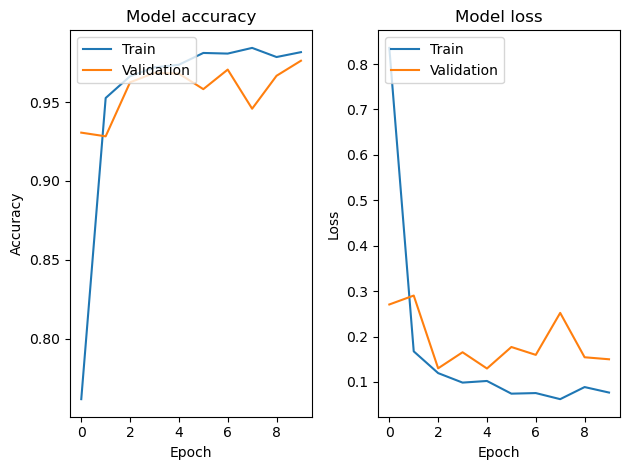

In [19]:
# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Evaluate model

Use the evaluate method on the test data provided by the test generator object (**test_generator**) .

In [20]:
test_metrics = model.evaluate(test_generator)
print("loss:",test_metrics[0], "accuracy:",test_metrics[1])

 8/73 [==>...........................] - ETA: 1s - loss: 0.0047 - accuracy: 0.9961

2023-11-22 13:54:17.732285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


73/73 [==============================] - 1s 14ms/step - loss: 0.0595 - accuracy: 0.9876
loss: 0.05946585163474083 accuracy: 0.9875856041908264


# Visualize the convolutional filters

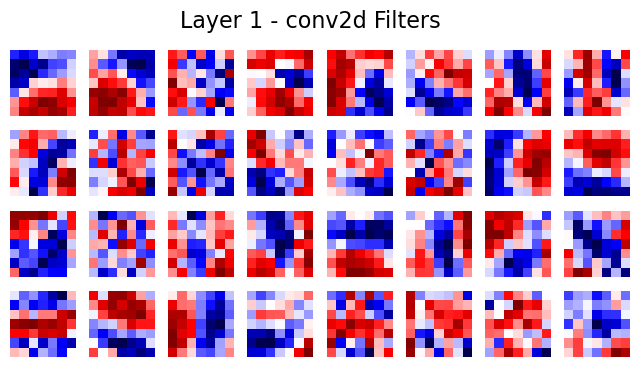

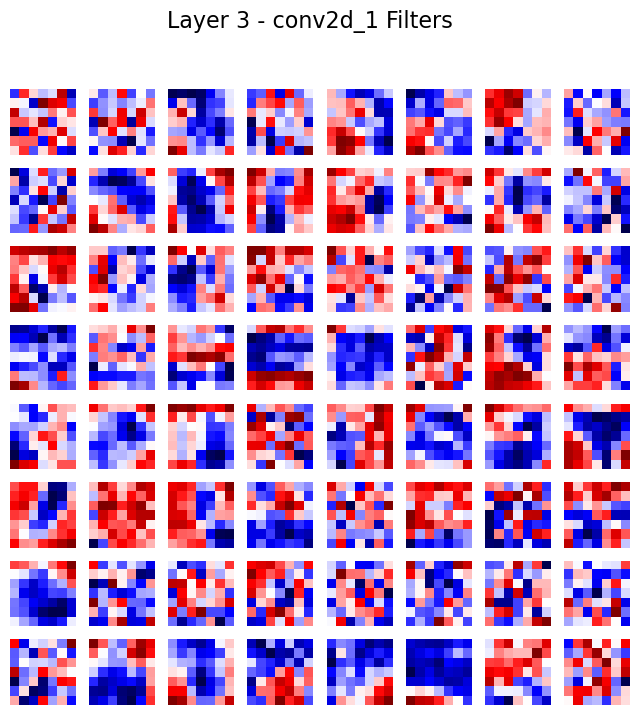

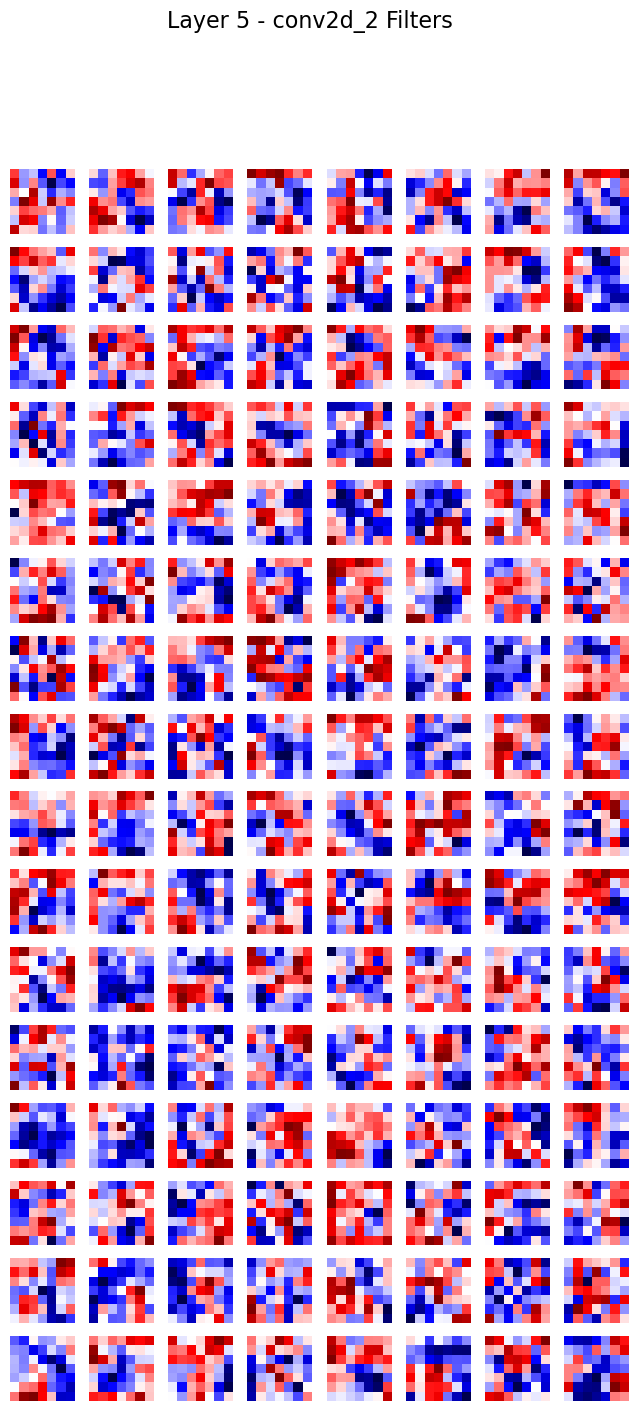

In [21]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# Function to plot the weights of a single filter
def plot_filter_weights(weights, filter_index, ax):
    # Extract the weights for a specific filter across all channels
    filter_weights = weights[:, :, :, filter_index]

    # Normalize the weights
    filter_weights -= filter_weights.mean()
    filter_weights /= filter_weights.std() + 1e-5  # Avoid division by zero

    # Displaying the mean filter weight across all channels
    filter_weights = np.mean(filter_weights, axis=-1)

    # Plotting
    ax.imshow(filter_weights, cmap='seismic')
    ax.axis('off')

# Loop through each convolutional layer
for layer_index, layer in enumerate(model.layers):
    if 'conv' in layer.name:
        filters, biases = layer.get_weights()
        n_filters = filters.shape[-1]

        # Set up the subplot dimensions
        n_cols = 8
        n_rows = n_filters // n_cols + (n_filters % n_cols > 0)
        
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
        fig.suptitle(f'Layer {layer_index + 1} - {layer.name} Filters', fontsize=16)

        for i in range(n_filters):
            ax = axs[i // n_cols, i % n_cols] if n_rows > 1 else axs[i % n_cols]
            plot_filter_weights(filters, i, ax)

        plt.show()


# Plot feature maps / activation maps

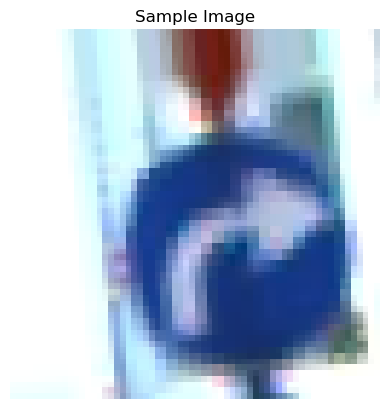

In [22]:

# Get a batch of images and labels
images_batch, labels_batch = next(train_generator)

# Select the first image from the batch as the sample
sample_image = images_batch[0]

# If you need to visualize the sample image
plt.imshow((sample_image-sample_image.min())/(sample_image.max()-sample_image.min()))
plt.title("Sample Image")
plt.axis('off')
plt.show()


1/1 [==============================] - 0s 123ms/step


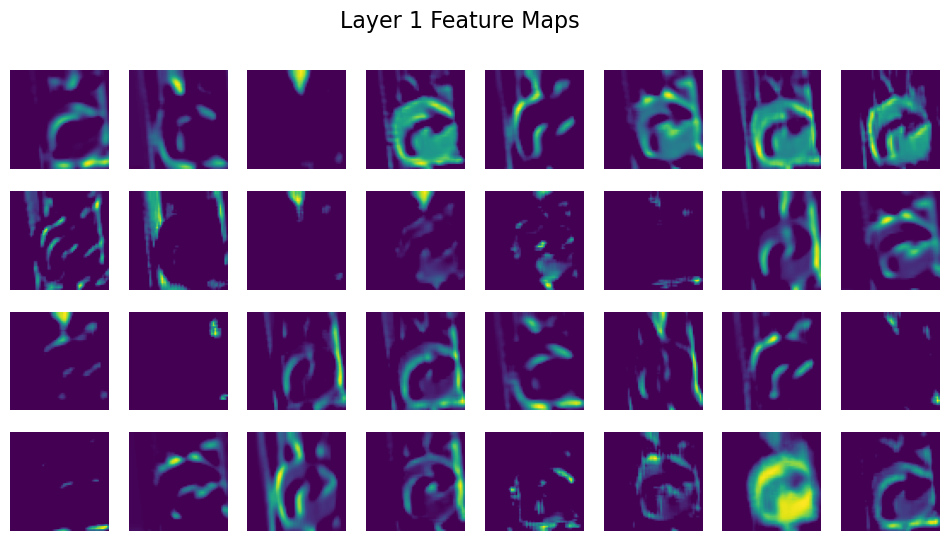

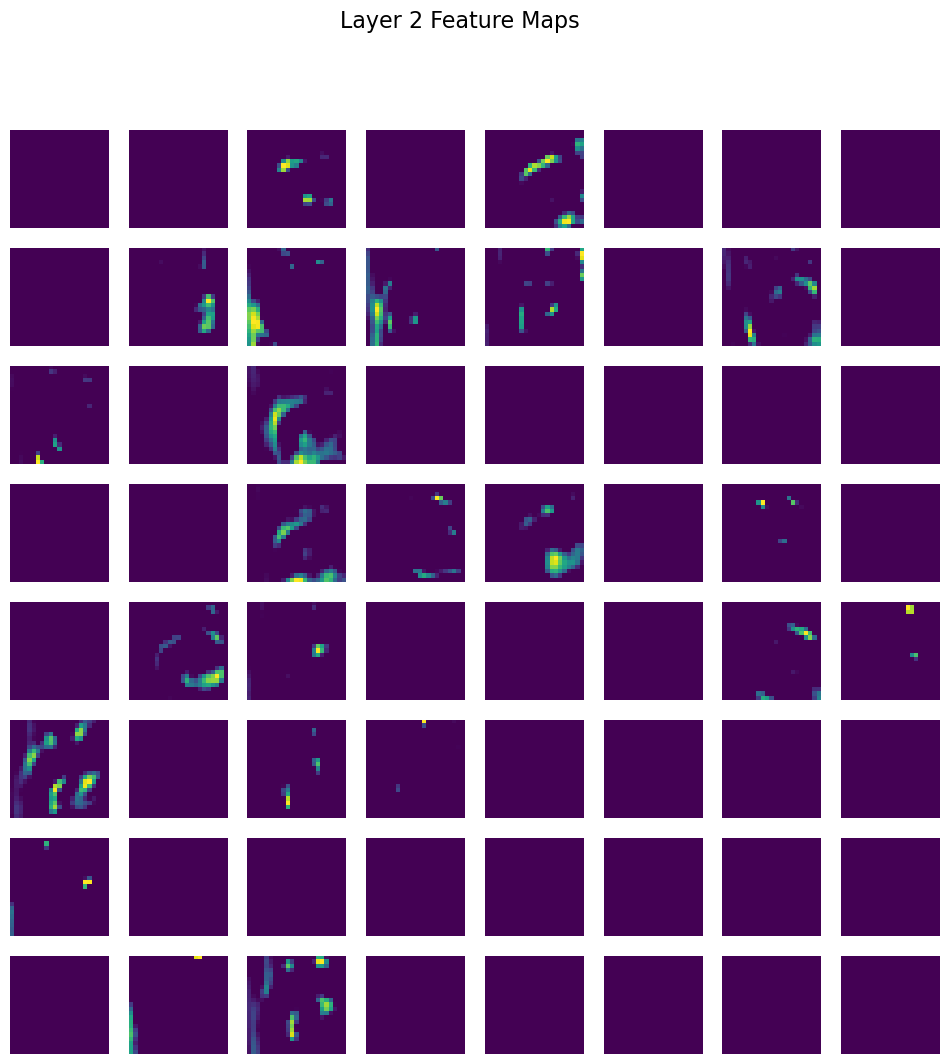

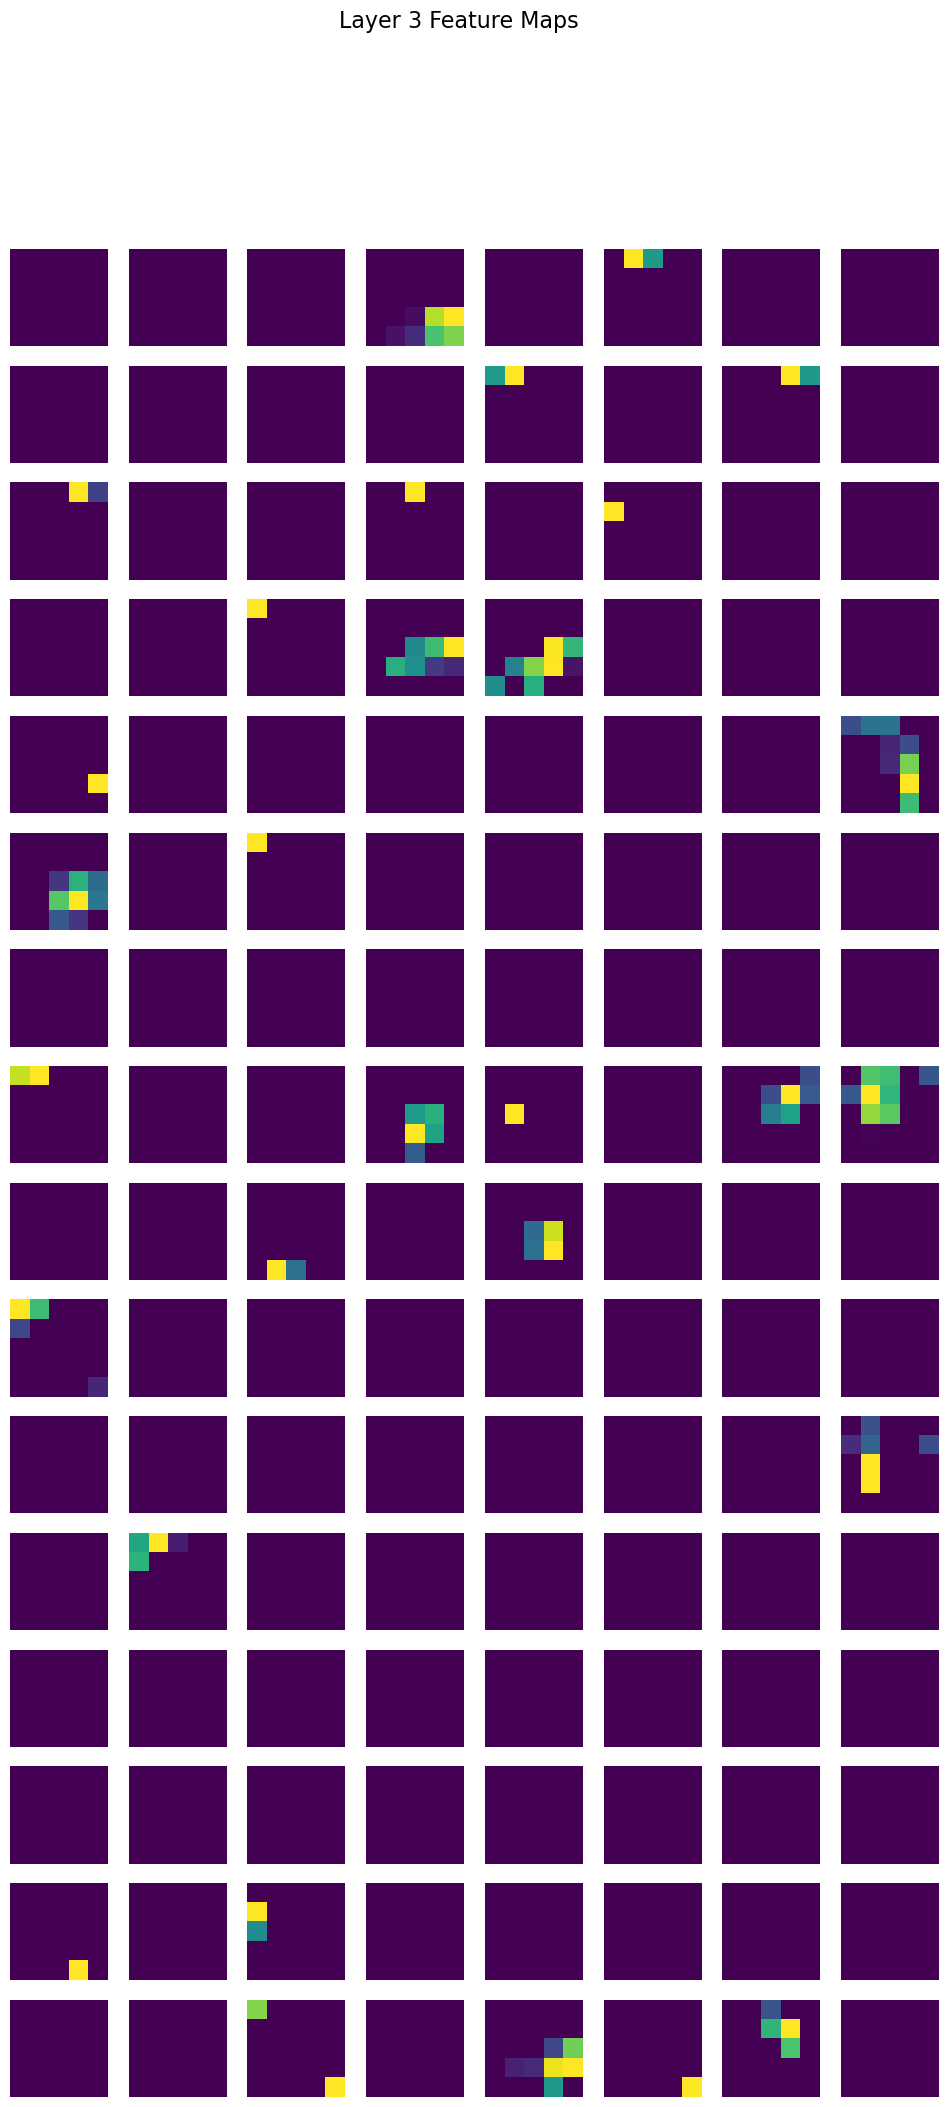

In [23]:
from tensorflow.keras.models import Model

# Reshape the image to match the input shape of the model
# (add one dimension for the batch dimension)
input_image = np.expand_dims(sample_image, axis=0)

# Create a new model that outputs the activations of the convolutional layers
layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get the feature maps
activations = activation_model.predict(input_image)

# Function to plot the feature maps of a single layer
def plot_feature_maps(activation_maps, ax, num_cols=8):
    num_features = activation_maps.shape[-1]
    size = activation_maps.shape[1]
    num_rows = num_features // num_cols + (num_features % num_cols > 0)

    for feature_map in range(num_features):
        ax = axs[feature_map // num_cols, feature_map % num_cols] if num_rows > 1 else axs[feature_map % num_cols]
        ax.imshow(activation_maps[0, :, :, feature_map], cmap='viridis')
        ax.axis('off')

# Plotting the feature maps for each convolutional layer
for layer_index, layer_activation in enumerate(activations):
    n_features = layer_activation.shape[-1]
    n_cols = 8
    n_rows = n_features // n_cols + (n_features % n_cols > 0)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 1.5, n_rows * 1.5))
    fig.suptitle(f'Layer {layer_index + 1} Feature Maps', fontsize=16)

    plot_feature_maps(layer_activation, axs, num_cols=n_cols)

    plt.show()

## Make predictions

Once the model is fully trained, it can be used to make predictions from unseen data. Use the `predict()` method on the test generator, store the result in some variable, and print out the shape of the variable (NumPy array).

In [24]:
y_pred = model.predict(test_generator)

print(y_pred.shape)

 8/73 [==>...........................] - ETA: 0s

2023-11-22 13:54:27.466710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


73/73 [==============================] - 1s 8ms/step
(2336, 43)


As you can see, the predictions were made for the whole training dataset, and we get 43 class probabilities for all 2336 data items. Using the argmax function in the following way (with axis=-1), we get the class index for each data item. We have to provide the axis (dimension to be used), as otherwise the function returns only one index, where the maximum value is stored for all data items. But we want the maximum index per row (data item). Using -1 for axis, we choose the last index. (Another option would be to use axis=1, because we have 2 axes, and axis 0 is for the 2336 data items, and axis 1 for the 43 probabilities.)

Printing the predicted labels gives us 2336 values between 0 and 42 (for the 43 categories).

In [25]:
# TODO: compute predicted classes from class scores y_pred.

y_pred_cls = np.argmax(y_pred, axis=-1)

print(y_pred_cls)

[ 0  0  0 ...  6 42 42]


Let's get the ground truth values from the test_generator as well and compute the accuracy:

In [28]:
# Get the true labels
y_true = test_generator.classes

# Calculate accuracy
accuracy = np.mean(y_pred_cls == y_true)
print(f'Accuracy on test set: {accuracy:.2f}')

Accuracy on test set: 0.99


To visually evaluate the results, predictions are made in the next cell for one batch of 32 images, And then, the images of the batch together with the predicted labels and the true labels (in parenthesis) are plotted. (Rerun this cell to get other random input images.)

2023-11-22 13:54:28.194160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,64,64,3]
	 [[{{node Placeholder/_0}}]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for in

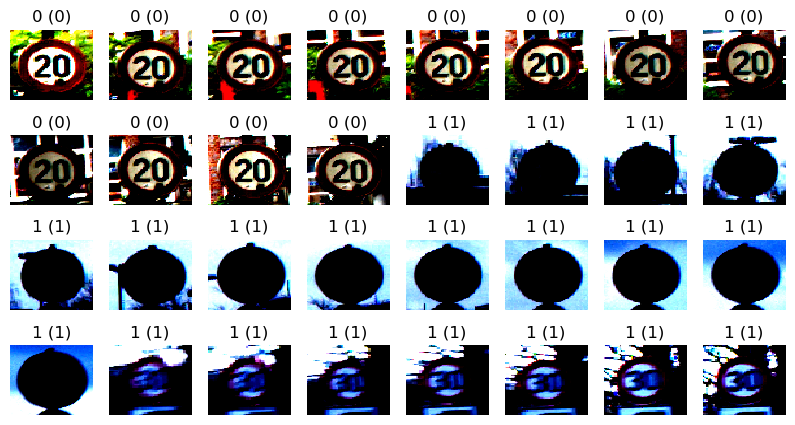

In [27]:
x, y = test_generator.next()

y_pred_probs = model.predict_on_batch(x)

y_pred = np.argmax(y_pred_probs, axis=-1)

n_rows = 4
n_cols = 8

plt.figure(figsize = (10,5))

for r,c in itertools.product(range(n_rows), range(n_cols)):
    index = n_cols * r + c
    plt.subplot(n_rows, n_cols, index + 1)
    plt.imshow(x[index], interpolation="nearest", aspect='auto')
    plt.axis('off')
    plt.title(f'{y_pred[index]} ({int(y[index])})', fontsize=12) 
    
plt.subplots_adjust(wspace=0.2, hspace=0.5)

This brings us to the end of the exercise. However, you could adapt the network to use more layers, more units per layer, etc. in order to improve the accuracy. Once you are happy with the accuracy of your validation data, check your accuracy with the test data. But you should not try to optimize any hyperparameters (number of layers, units per layer, training epochs) towards the test data. Otherwise you are not playing fair and you do not get a realistic idea of how well your network performs in the end.

As a last note. Check the number of trainable parameters from the model summary. These are quite a lot for this comparable easy task. Later, when using convolutional neural networks, we will decrease the number of trainable parameters, and at the same time increase the reachable accuracy. That being said, image classification with fully connected networks is generally not the best way to do it. And we will later see why.